
# Flows in Free Convolution

## Goals of this script: Solving the complex Burgers equation and computing the associated semi-group for free convolution.


---------------------------------------------------------------------------------------------
# Solving the complex Burgers equation
Let $\mu^t$ denote the particle measure arising in the hydrodynamical limit / spectral measure arising from free probability. Its Stieljes transform is
$$ G(t,z) = \int_{\mathbb{R}} \frac{\mu^t(dx)}{z-x} \ .$$

Here we want to solve
$$ \partial_t G + \varphi( G ) \partial_z G = 0$$
By the method of characteristics, $t \mapsto G(t, z(t))$ is constant along the characteristic $z(t) := z + t \varphi(1/z)$. As such:
$$ \forall w \in \mathbb{C}^-, \
   w = G(0,1/w) = G(t, z(t) ) = G\left( t, \frac{1}{w} + t \varphi(w) \right) \ .$$

## 1. Computation of $G$

In [22]:
import time
import numpy as np
import matplotlib.pyplot as plt

# Parameters of the freely infinitely divisible distribution
# Convention: 
# - 1st element  : Gaussian component
# - Next elements: Atoms
parameters = [0, 3, 5]
total_mass = len(parameters)-1
#parameters = [1]

#Initial condition
#At t=0, \mu^t = \delta_0(dx) implies that its Stieljes transform is 1/z
def G_0(z):
    return 1/z

#Function defining the R transform of the Levy-Khintchine exponent
def phi(z):
    #return z          #Semi circle
    #return 1/(1-z)    #Marchenko-Pastur
    #return 1/(1/3-z)  #Marchenko-Pastur with Dirac at 3
    value = parameters[0]*z
    for i in range(1, len(parameters)):
        value += 1/( 1/parameters[i] - z)
    return value

def phi_prime(z):
    #return 1 #Semi-circle
    #return 1/( (1-z)*(1-z) ) #Marchenko Pastur
    #return 1/( (1/3-z)*(1/3-z) ) #Marchenko-Pastur with Dirac at 3
    #return 1/( (1-z)*(1-z) ) + 1/( (1/3-z)*(1/3-z) )
    value = parameters[0]
    for i in range(1, len(parameters)):
        value += 1/( (1/parameters[i] - z)*(1/parameters[i] - z) )
    return value

In [4]:
# Classes wrapping functions for NR scheme using Kantorovich theorem for convergence

# Use case: 
# - Need that away from axis f_z( 1/z ) \approx 0
# - No exact proxy is available but good control on attraction basins
# - Poor bound on second derivative
class Kantorovich_Wrapper_1:
    
    def f(self, t, w, z):
        return z - (1/w) - t *phi(w)

    def f_prime(self, t, w, z):
        return 1/(w*w) - t*phi_prime(w) 

    def f_second_bound(self, t, w, z, ball_max_y):
        return -2/(ball_max_y**3) - t*total_mass/(ball_max_y**3)
    
# Use case: 
# - Need exact proxy
# - Better bound on second derivative
class Kantorovich_Wrapper_2:
    def f(self, t, w, z):
        return w*z - 1 - t*w*phi(w)

    def f_prime(self, t, w, z):
        return z - t*phi(w) - t*w*phi_prime(w) 

    # NOT PROVEN BUT WORKS!
    def f_second_bound(self, t, w, z, ball_max_y):
        return t*total_mass*( -1/(ball_max_y**2) )

# Polynome case:
class Kantorovitch_Wrapper_3:

    def f(self, coefs_list, z):
        P=0
        for k,coef in enumerate(coefs_list):
            P += coef*z**k
        return P
    
    def f_prime(self, coefs_list, z):
        P=0
        for k,coef in enumerate(coefs_list):
            P += k*coef*z**(k-1)
        return P
    
    def f_second_bound(self, coefs_list, ball_center, ball_radius):
        bound = 0
        for k,coef in enumerate(coefs_list):
            bound+= k*(k-1)*math.sqrt(coef.real**2+coef.imag**2)*(math.sqrt(ball_center.real**2+ball_center.imag**2)+ball_radius)**(k-2)
        return bound


In [12]:
DEFAULT_PRECISION = 1e-8

def is_in_basin(t, z, w, function_wrapper, debug=False):
    value      = function_wrapper.f(t, w, z)
    derivative = function_wrapper.f_prime(t, w, z)
    # Compute w value after one step
    step  = -value / derivative
    new_w = w + step
    if debug:
        print("")
        print("Call is_in_basin for z=",z)
        print("value:     ", value)
        print("derivative:", derivative)
        print(w)
        print(new_w)
        print("Im(w + h_0): ", new_w.imag)
    # Check if new_w in domain
    if new_w.imag >= 0:
        return False
    # Check if NR ball is in domain
    ball_max_y = new_w.imag + abs(step.imag)
    if debug:
        print("Im(w + h_0) + |Im(h_0)|: ", ball_max_y)
    if ball_max_y >= 0:
        return False
    # Compute bound on second derivative
    bound_f_2 = function_wrapper.f_second_bound(t, w, z, ball_max_y)
    criterion = abs(step/derivative)*bound_f_2
    if debug:
        print("criterion: ", criterion)
    return criterion < 0.5

#Computes the Stieljes transform of free semi-group
# Uses a Newton-Raphson iteration for inverting and finding the w such that:
# 1/w + t \phi(w) = z
# Guess is not necessarily in basin of attraction
def compute_G_NR(t, z, function_wrapper, guess=None, error=None):
    if guess is None:
        w = 1/z
    else:
        w = guess
    #
    if error is None:
        error = 1e-8
    #
    while True:
        value = function_wrapper.f(t, w, z)
        if ( abs(value) < error ):
            break
        grad = function_wrapper.f_prime(t, w, z)
        if ( abs(grad) < error ):
            print("Gradient too small!!")
            print("value: ", value)
            print("grad: ", grad)
            return None
            break
        #Newton-Raphson iteration
        w = w - value/grad
    #
    #print( "Newton-Raphson: ", value, grad)
    return w;

def reset_counters():
    global call_counter_failed_basin
    global call_counter_NR
    call_counter_failed_basin = 0
    call_counter_NR    = 0
    
def compute_G_adaptative(t, z_objective, proxy=None, debug=False):
    global call_counter_failed_basin
    global call_counter_NR
    j       = complex(0,1)
    #
    # If no proxy is available, find high enough z in basin of attraction and compute associated w
    # This search uses a doubling strategy
    if proxy is None: 
        fwrapper = Kantorovich_Wrapper_1()
        z = z_objective
        w = 1/(z-t*total_mass)
        while not is_in_basin(t, z, w, function_wrapper = fwrapper ):
            call_counter_failed_basin += 1
            z = z + j*z.imag
            w = 1/z
        w = compute_G_NR(t, z, function_wrapper = fwrapper, guess=w)
        if debug:
            print("Valid z: ", z)
            print("Guess w: ", 1/z)
            print("G(t,z) = ", w )
    else:
        z, w = proxy
        # Useless unless we use higher points for proxy
        # assert(z.real==z_objective.real)
        # assert(z.imag >z_objective.imag)
    if debug:
        print("Proxy (z,w): ", z, w)
    #
    # Starts heading towards the objective z
    while abs(z- z_objective)>0:
        fwrapper = Kantorovich_Wrapper_2()
        dz = z_objective-z
        while not is_in_basin(t, z+dz, w, function_wrapper=fwrapper):
            call_counter_failed_basin += 1
            dz = 0.5*dz
        z = z+dz
        w = compute_G_NR(t, z, function_wrapper=fwrapper, guess=w)
        call_counter_NR += 1
        if debug:
            print("Valid z: ", z)
            print("G(t,z) = ", w )
    # end while
    return w

j       = complex(0,1)
t       = 1
debug   = False
z_array = 1+ j*np.array([ 4, 1, 0.1, 0.01, 1e-3, 1e-5, 1e-8, 1e-10])
proxy   = None
for z in z_array:
    print("z: ", z)
    reset_counters()
    w = compute_G_adaptative(t, z, proxy=proxy)
    proxy = (z, w)
    print("G(t,z) = ", w )
    print("Number of calls to NR: ", call_counter_NR)
    print("Number of calls to attraction basin test: ", call_counter_failed_basin)
    print("")


z:  (1+4j)
G(t,z) =  (-0.08246287454736088-0.11102307957796616j)
Number of calls to NR:  1
Number of calls to attraction basin test:  5

z:  (1+1j)
G(t,z) =  (-0.1983419793249723-0.1790795065672346j)
Number of calls to NR:  1
Number of calls to attraction basin test:  0

z:  (1+0.1j)
G(t,z) =  (-0.3447826206119937-0.3076697934253887j)
Number of calls to NR:  2
Number of calls to attraction basin test:  0

z:  (1+0.01j)
G(t,z) =  (-0.36200484021844614-0.34698154086855754j)
Number of calls to NR:  2
Number of calls to attraction basin test:  0

z:  (1+0.001j)
G(t,z) =  (-0.36338979812576583-0.3514180744414969j)
Number of calls to NR:  2
Number of calls to attraction basin test:  0

z:  (1+1e-05j)
G(t,z) =  (-0.36353731823123747-0.35191143332721064j)
Number of calls to NR:  2
Number of calls to attraction basin test:  0

z:  (1+1e-08j)
G(t,z) =  (-0.3635388018849735-0.35191641710603166j)
Number of calls to NR:  2
Number of calls to attraction basin test:  0

z:  (1+1e-10j)
G(t,z) =  (-0.3

## 2 Computation of the measure (multiple passes)

Pass [1/4], Duration: 114.3 ms
Number of calls to NR:  1773
Number of calls to attraction basin test:  2806

Pass [2/4], Duration: 122.9 ms
Number of calls to NR:  3611
Number of calls to attraction basin test:  2131

Pass [3/4], Duration: 116.6 ms
Number of calls to NR:  3680
Number of calls to attraction basin test:  2241

Pass [4/4], Duration: 103.7 ms
Number of calls to NR:  3711
Number of calls to attraction basin test:  2283



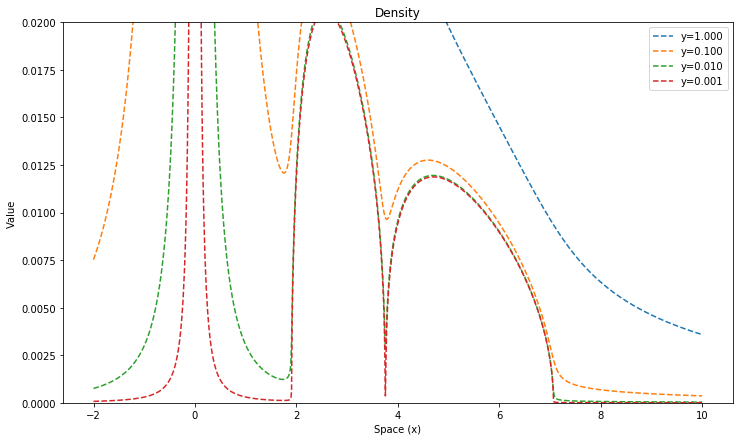

In [23]:
#Imports for 3d
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

#T: Time
#M: Time mesh
T=0.03
M=150
#N: Space mesh
N=1000
a=-2
b=10

#Init
time_grid  = [ T*(k/M)*(k/M) for k in range(M)]
space_grid = np.linspace(a, b, N)
dt = T/M
dx = (b-a)/N

#Multiple passes for the number of iterations
#imaginary_parts = [2, 1.0, 0.5, 0.3, 0.1, 0.005, 0.001]
#imaginary_parts = [4.0, 1.0, 0.5, 0.1]
imaginary_parts = [1.0, 0.1, 0.01, 0.001]
densities       = []
hilbert_transf  = []
pass_counter    = 0
iter_count      = [ [] for i in space_grid ]
errors1         = [ [] for i in space_grid ]
errors2         = [ [] for i in space_grid ]
choices         = [ [] for i in space_grid ]

j       = complex(0,1)
fig = plt.figure( figsize = (12,7) )
ax = fig.add_subplot( 111 )
y_proxy = None
guess   = None
G       = np.array( space_grid + complex(0,1) )
for y in imaginary_parts:
    start = time.time()
    reset_counters()
    # Compute
    z = np.array( space_grid + y*complex(0,1) )
    for i in range(N):
        if y_proxy is None:
            G[i] = compute_G_adaptative(T, z[i], proxy=None)
        else:
            guess = (z[i].real+j*y_proxy, G[i])
            G[i] = compute_G_adaptative(T, z[i], proxy=guess)
    # Statistics
    pass_counter += 1
    timing        = time.time() - start
    print ('Pass [{}/{}], Duration: {:.1f} ms' 
           .format(pass_counter, len(imaginary_parts), 1000*timing))
    print("Number of calls to NR: ", call_counter_NR)
    print("Number of calls to attraction basin test: ", call_counter_failed_basin)
    print("")
    # Plot
    ax.plot(space_grid, -np.imag(G)/np.pi, '--', label="y=%.3f"%y)
    ax.set(xlabel='Space (x)', ylabel='Value',
           title='Density')
    ax.grid()
    #
    y_proxy = y
plt.ylim(0,0.02)
plt.legend()
plt.show()
